# HW4

In [1]:
import numpy as np
import pandas as pd
from graphviz import Digraph, Graph

In [2]:
data = pd.read_csv('titanic_data.csv')

data.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


## 4.1

In [3]:
data1 = data
data1.iloc[:,1] = data1.iloc[:,1].apply(lambda x: 1 if x == 3 else 0)
data1.iloc[:,3] = data1.iloc[:,3].apply(lambda x: 1 if x > 28 else 0)
data1.iloc[:,4] = data1.iloc[:,4].apply(lambda x: 1 if x > 0 else 0)
data1.iloc[:,5] = data1.iloc[:,5].apply(lambda x: 1 if x > 0 else 0)
data1.iloc[:,6] = data1.iloc[:,6].apply(lambda x: 1 if x > 14.45 else 0)

I extract the feature that are not binary, I evaluate the median of them, and do one-hot encoding based on the median.

There are 3 values in **Pclass**, I encode 3 as 1 and others as 0.

The data in **age** range from 0.42 to 80, I take data larger than median 28 as 1, others as 0.

There are 9 values (0-8) in **Siblings/Spouses Aboard**, I take data larger than median 0 as 1, others as 0.

There are 7 values (0-6) in **Parents/Children Aboard**, I take data larger than median 0 as 1, others as 0.

The data in **Fare** range from 0 to 512.3, I take data larger than median 14.45 as 1, others as 0.

In [4]:
data1.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,1,0,0,1,0,0
1,1,0,1,1,1,0,1
2,1,1,1,0,0,0,0
3,1,0,1,1,1,0,1
4,0,1,0,1,0,0,0


## 4.2

In [5]:
y = data1.Survived
X = data1.loc[:,'Pclass':"Fare"]

In [6]:
X.shape[1]

6

In [7]:
## follows deck8 8-3
def mutual(x,y):
    px = np.bincount(x)/x.shape[0]
    Hx = - (px * np.log2(px)).sum()
    
    py = np.bincount(y)/y.shape[0]
    if py.shape[0] == 1:
        np.append(py,0)
    px_y0 = np.bincount(x[y == 0])/x[y == 0].shape[0]
    px_y1 = np.bincount(x[y == 1])/x[y == 1].shape[0]
    
    Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]
    
    return Hx - Hy_x

In [8]:
x = data1.Pclass
x

0      1
1      0
2      1
3      0
4      1
      ..
882    0
883    0
884    1
885    0
886    1
Name: Pclass, Length: 887, dtype: int64

In [9]:
mutual(x,y)

0.07479007046514474

## 4.3

In [10]:
def pick_split(X):
    mu = X.apply(lambda x: mutual(y, x))
    return pd.Series.idxmax(mu), np.max(mu)

In [11]:
pick_split(X)

('Sex', 0.21684950483126508)

I used early stopping to prevent overfitting. I stop split when there are too few samples on each branch (fewer than the number of features).

# Now we construct classfier

In [29]:
class Node():
    def __init__(self, data, depth = 1, val = None):
        self.left = None
        self.right = None
        self.data = data
        self.y = self.data.Survived
        self.X = self.data.drop(['Survived'],axis = 1)
        
        ## for to_graphviz
        self.val = 'leaf, depth = ' + str(depth) + ' ' + str(val)
        
        self.y_pre = 1 if self.y.sum() >= len(self.y)/2 else 0
        self.label = "y_prediction = " + str(self.y_pre)
        
        ## for prediction
        self.feature = None
        
        
        if self.X.drop_duplicates().shape[0] > self.X.shape[1]:
            feature, mut_info = self.pick_split()
            ## for prediction
            self.feature = feature
            
            # for to_graphviz
            self.val = feature + " = 1? depth = " + str(depth) + str(val)
            self.label = feature + " = 1? "
            
            # split data recursively
            data_left = self.data[self.data[feature] == 0]
            #print(data_left)
            data_right = self.data[self.data[feature] == 1]
            
            self.left = Node(data_left, depth + 1, self.val + 'yes')
            self.right = Node(data_right, depth + 1, self.val + 'no') 
        
    def pick_split(self):
        ## follows deck8 8-3
        def mutual(x, y):
            px = np.bincount(x)/x.shape[0]
            Hx = - (px * np.log2(px)).sum()

            py = np.bincount(y)/y.shape[0]
            if len(py) == 1:
                py = np.append(py,0)
            px_y0 = np.bincount(x[y == 0])/x[y == 0].shape[0]
            px_y1 = np.bincount(x[y == 1])/x[y == 1].shape[0]
            
            #print(py)
            Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]

            return Hx - Hy_x

        mut = self.X.apply(lambda x: mutual(self.y, x))
        val = np.max(mut)
        feature = pd.Series.idxmax(mut)

        return feature, val
        
    def to_graphviz(self, g = None):
        if g == None:
            g = Digraph()
        
        # draw self node
        g.node(self.val, self.label)
        
        for label, child in [('False', self.left), ('True', self.right)]:
            if child != None:
                # draw child node recursively
                child.to_graphviz(g)
                
                # draw edge from self to child
                g.edge(self.val, child.val, label = label)
        return g
    
    def _repr_svg_(self):
        return self.to_graphviz()._repr_svg_()
        
     
    def _predict(self,new):
        if self.left == None and self.right == None:
            return self.y_pre
        
        #print(self.label)
        
        if new[self.feature] == 0:
            return self.left._predict(new)
        else:
            return self.right._predict(new)
        
    def predict(self, new):
        if len(new.shape) == 1: ## single observation
            return self._predict(new)
        else:
            return new.apply(lambda x: self._predict(x), axis = 1)

    

In [30]:
class BST:
    data = pd.read_csv('titanic_data.csv')
    def __init__(self):
        self.data = BST.data
        
        self.data.iloc[:,1] = self.data.iloc[:,1].apply(lambda x: 1 if x == 3 else 0)
        self.data.iloc[:,3] = self.data.iloc[:,3].apply(lambda x: 1 if x > 28 else 0)
        self.data.iloc[:,4] = self.data.iloc[:,4].apply(lambda x: 1 if x > 0 else 0)
        self.data.iloc[:,5] = self.data.iloc[:,5].apply(lambda x: 1 if x > 0 else 0)
        self.data.iloc[:,6] = self.data.iloc[:,6].apply(lambda x: 1 if x > 14.45 else 0)
        
        self.y = self.data.Survived
        self.X = self.data.loc[:,'Pclass':"Fare"]
        
        
    
    
    def create_tree(self, data):
        self.tree = Node(data)
        
        return self.tree
    
    ## prob 4.5
    def cross_val(self, fold = 10):
        indices = np.random.permutation(list(self.data.index))
        testsize = self.data.shape[0]//fold
        acc = []
        for i in range(fold):
            if i == 9:
                test = self.data.loc[indices[i*testsize:]]
                train = self.data.loc[self.data.index.isin(indices[i*testsize:]) == False]
            else:
                test = self.data.loc[indices[i*testsize : (i+1)*testsize]]
                train = self.data.loc[self.data.index.isin(indices[i*testsize : (i+1)*testsize]) == False]
            
            tree = self.create_tree(train)
            acc.append((tree.predict(test) == test.Survived).sum()/len(test.Survived))
            
        return np.array(acc).mean()

## 4.4

This is the tree I construct:

![tree]("tree.png")

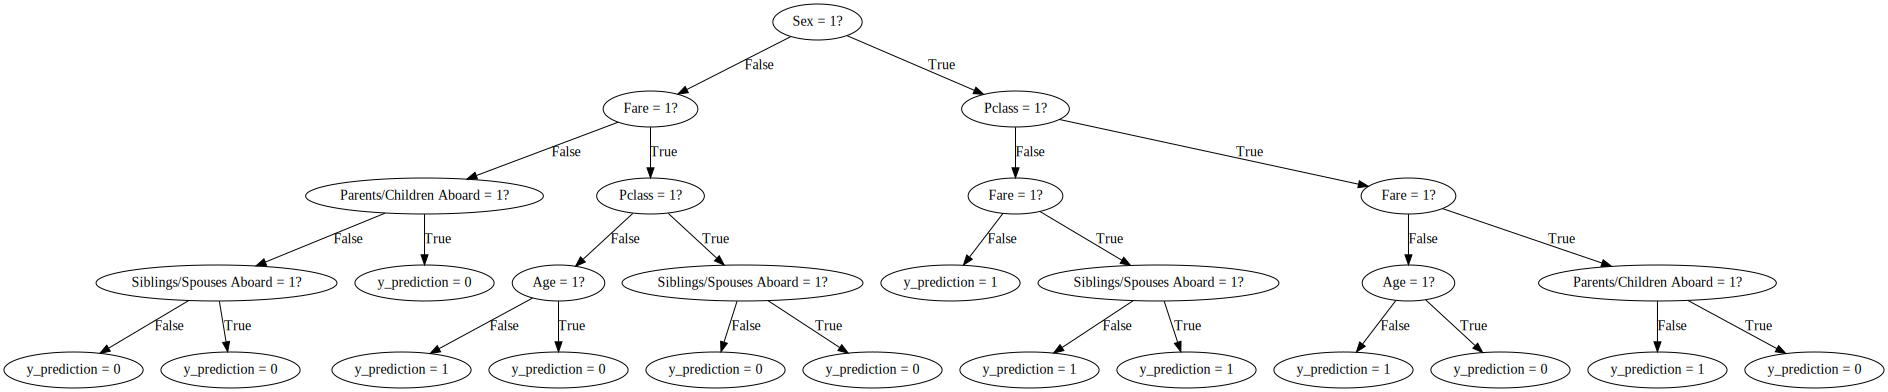

In [31]:
## Please run this cell after running the appendix
Total = BST()
tree = Total.create_tree(Total.data)
tree

## 4.5

In [32]:
Total.cross_val()

<ipython-input-29-8af5dfa69e2f>:49: RuntimeWarning: divide by zero encountered in log2
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]
<ipython-input-29-8af5dfa69e2f>:49: RuntimeWarning: invalid value encountered in multiply
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]


0.7866507177033493

I got accuracy as above.

## 4.6

My own feature would be Plass:3, Gender:0, Age:23, Siblings:0, Parents/Children:0, Fare: 7.25.

In [33]:
new = pd.Series({'Survived':None, 'Pclass':3, 'Sex':0, 'Age': 23, 'Siblings/Spouses Aboard': 1, 'Parents/Children Aboard':0, 'Fare': 0})
new
tree.predict(new)

0

I would not survived the Titanic sinking based on the decision tree prediction.

## 4.7

In [34]:
def RandomForest(data, tree_size = 5, sample_subset = 0.8):
    size = round(data.shape[0] * sample_subset)
    BSTs = []
    trees = []
    for i in range(tree_size):
        BSTs.append(BST())
        indices = np.random.permutation(list(data.index))
        trees.append(BSTs[i].create_tree(data.loc[indices[:size]]))
    
    return BSTs,trees

### (a)

<ipython-input-29-8af5dfa69e2f>:49: RuntimeWarning: divide by zero encountered in log2
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]
<ipython-input-29-8af5dfa69e2f>:49: RuntimeWarning: invalid value encountered in multiply
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]


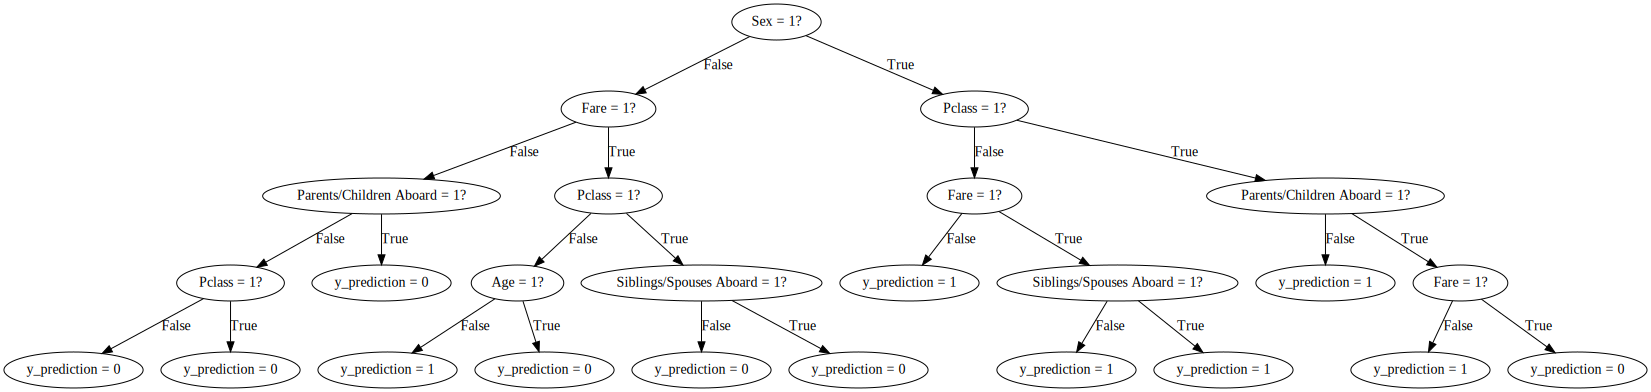

In [35]:
BSTs,RF = RandomForest(data1, tree_size = 5)
RF[0]

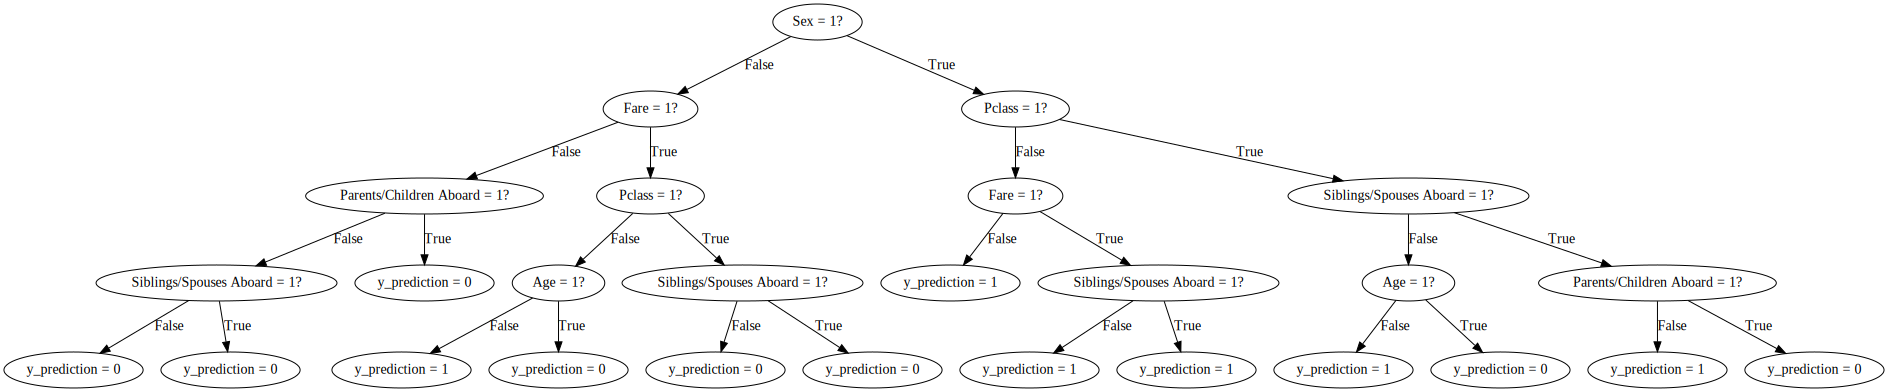

In [36]:
RF[1]

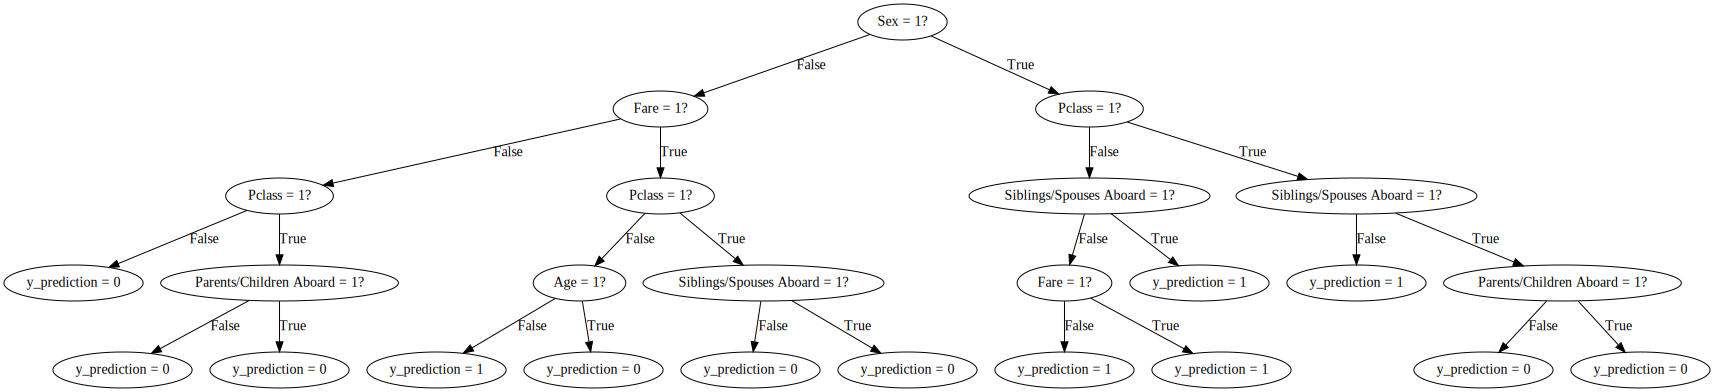

In [37]:
RF[2]

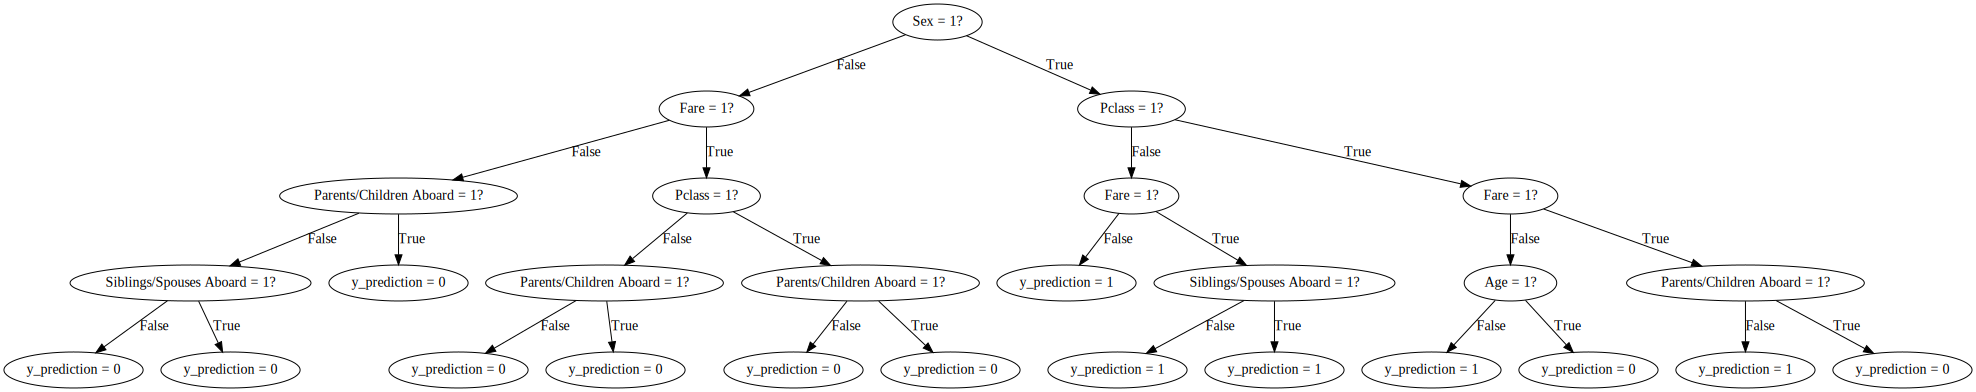

In [38]:
RF[3]

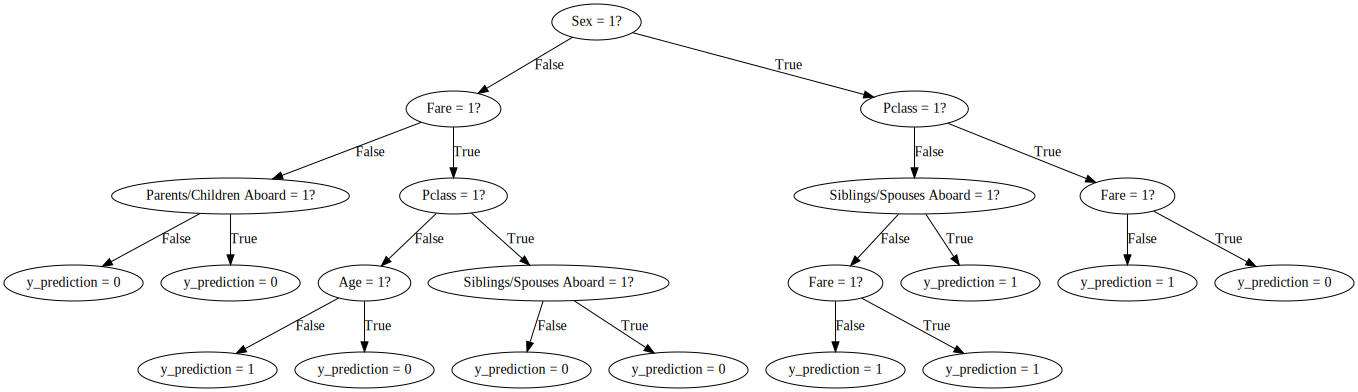

In [39]:
RF[4]

### (b)

In [23]:
def RF_cross_val(data, fold = 10):
        indices = np.random.permutation(list(data.index))
        testsize = data.shape[0]//fold
        acc = []
        for i in range(fold):
            if i == 9:
                test = data.loc[indices[i*testsize:]]
                train = data.loc[data.index.isin(indices[i*testsize:]) == False]
            else:
                test = data.loc[indices[i*testsize : (i+1)*testsize]]
                train = data.loc[data.index.isin(indices[i*testsize : (i+1)*testsize]) == False]
            
            print(train.shape)
            BSTs, RF = RandomForest(train, tree_size = 5, sample_subset = 0.8)
            
            pre = np.array([itree.predict(test) for itree in RF])
            
            ## summarize 5 trees result
            pre_total = pre.sum(0)
            pre_total[pre_total < 3] = 0
            pre_total[pre_total >= 3] = 1
            
            acc.append((pre_total == test.Survived).sum()/len(test.Survived))
            
        #return np.array(acc).mean()
        return acc

In [24]:
acc = RF_cross_val(data1, fold = 10)

(799, 7)
(799, 7)
(799, 7)


<ipython-input-12-29b4f1d4083d>:49: RuntimeWarning: divide by zero encountered in log2
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]
<ipython-input-12-29b4f1d4083d>:49: RuntimeWarning: invalid value encountered in multiply
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]


(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(792, 7)


In [25]:
acc

[0.6363636363636364,
 0.6590909090909091,
 0.5340909090909091,
 0.5909090909090909,
 0.6704545454545454,
 0.5568181818181818,
 0.6590909090909091,
 0.5568181818181818,
 0.625,
 0.6526315789473685]

In [26]:
np.array(acc).mean()

0.6141267942583732

I got accuracy as above when using 10-fold CV on random forest.

### (c)

In [27]:
def RF_pre(new):
    BSTs, RF = RandomForest(data1, tree_size = 5, sample_subset = 0.8)
            
    pre = np.array([itree.predict(new) for itree in RF])
    ## summarize 5 trees result
    pre_total = pre.sum(0)
    res = 1 if pre_total >= 3 else 0
    return res

In [28]:
new = pd.Series({'Survived':None, 'Pclass':3, 'Sex':0, 'Age': 23, 'Siblings/Spouses Aboard': 1, 'Parents/Children Aboard':0, 'Fare': 0})
RF_pre(new)

<ipython-input-12-29b4f1d4083d>:49: RuntimeWarning: divide by zero encountered in log2
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]
<ipython-input-12-29b4f1d4083d>:49: RuntimeWarning: invalid value encountered in multiply
  Hy_x = - (px_y0 * np.log2(px_y0)).sum()* py[0] - (px_y1 * np.log2(px_y1)).sum()* py[1]


0

I would not survived the Titanic sinking based on the decision tree prediction.

## 4.8

In [54]:
def RandomForest2(data, tree_size = 6):
    BSTs = []
    trees = []
    feat = data.columns
    
    for i in range(tree_size):
        BSTs.append(BST())

        trees.append(BSTs[i].create_tree(data.drop([feat[i+1]], axis = 1)))
    
    return BSTs,trees

### (a)

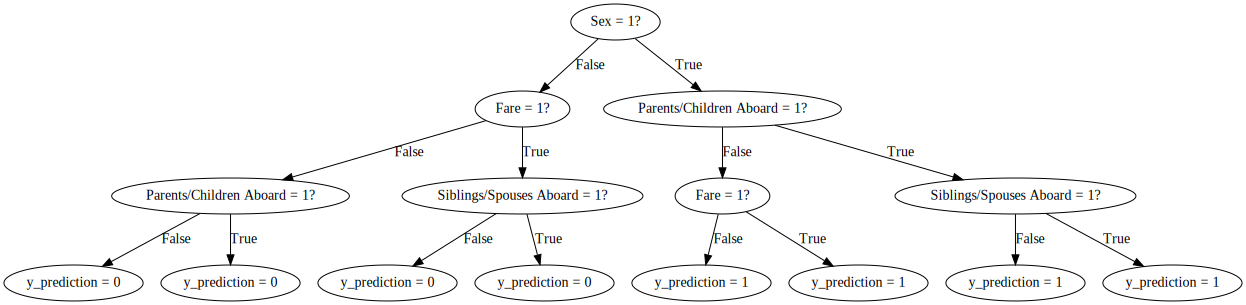

In [55]:
BSTs,RF = RandomForest2(data1, tree_size = 6)
RF[0]

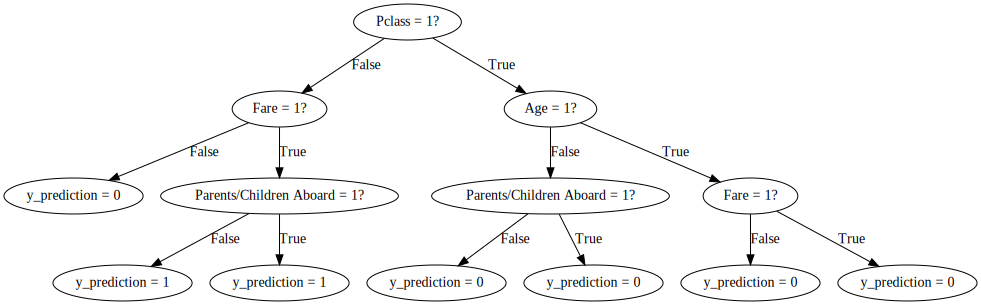

In [56]:
RF[1]

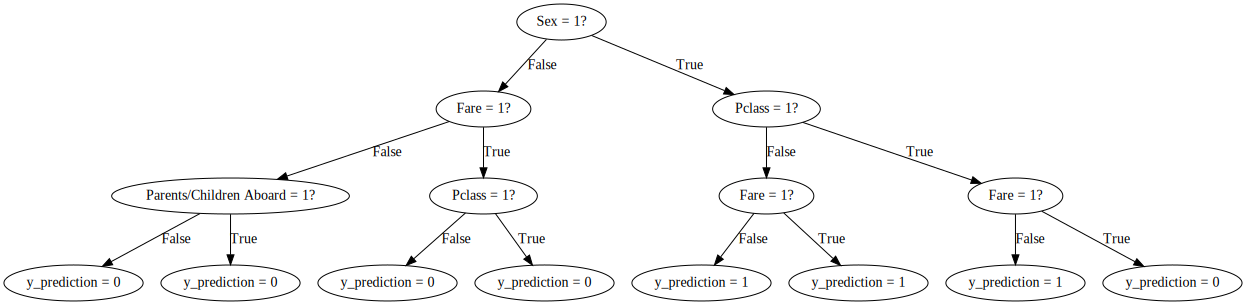

In [57]:
RF[2]

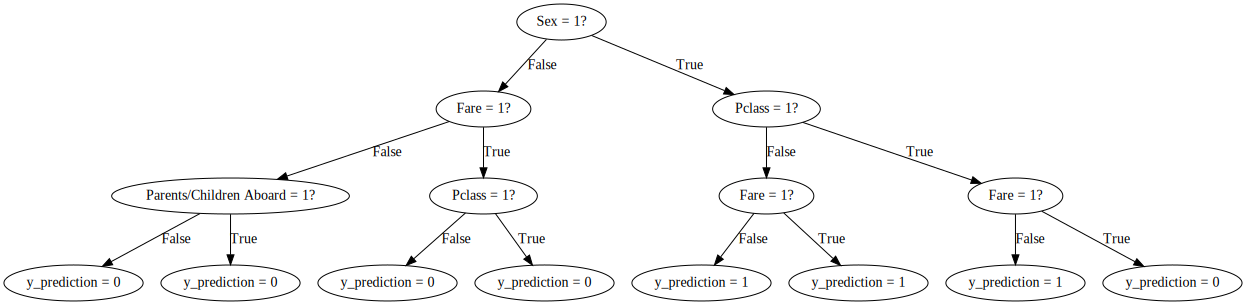

In [58]:
RF[3]

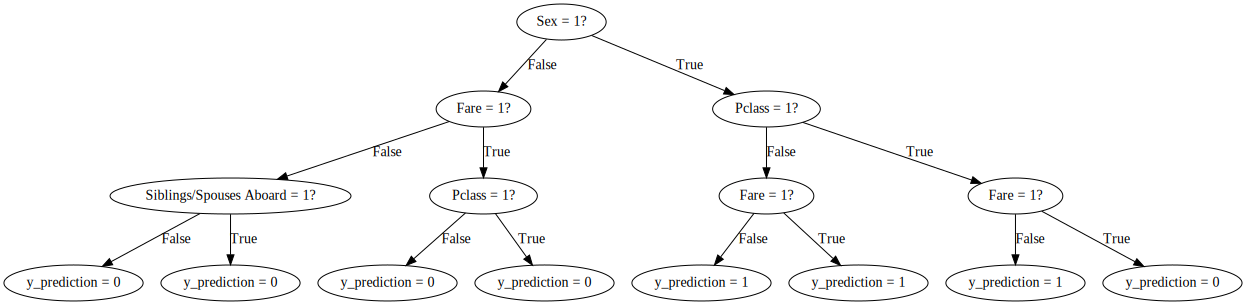

In [59]:
RF[4]

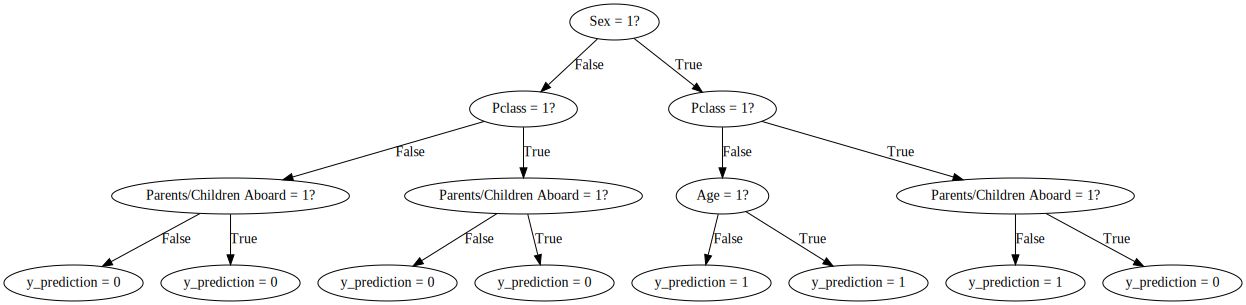

In [60]:
RF[5]

### (b)

In [67]:
def RF2_cross_val(data, fold = 10):
        indices = np.random.permutation(list(data.index))
        testsize = data.shape[0]//fold
        acc = []
        for i in range(fold):
            if i == 9:
                test = data.loc[indices[i*testsize:]]
                train = data.loc[data.index.isin(indices[i*testsize:]) == False]
            else:
                test = data.loc[indices[i*testsize : (i+1)*testsize]]
                train = data.loc[data.index.isin(indices[i*testsize : (i+1)*testsize]) == False]
            
            print(train.shape)
            BSTs, RF = RandomForest2(train, tree_size = 6)
            
            pre = np.array([itree.predict(test) for itree in RF])
            
            ## summarize 5 trees result
            pre_total = pre.sum(0)
            pre_total[pre_total <= 3] = 0
            pre_total[pre_total > 3] = 1
            
            acc.append((pre_total == test.Survived).sum()/len(test.Survived))
            
        #return np.array(acc).mean()
        return acc

In [68]:
acc = RF2_cross_val(data1, fold = 10)

(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(799, 7)
(792, 7)


In [69]:
acc

[0.7840909090909091,
 0.6931818181818182,
 0.8522727272727273,
 0.7954545454545454,
 0.7386363636363636,
 0.7727272727272727,
 0.875,
 0.8181818181818182,
 0.8181818181818182,
 0.7473684210526316]

In [70]:
np.array(acc).mean()

0.7895095693779905

I got accuracy as above when using 10-fold CV on random forest.

### (c)

In [71]:
def RF2_pre(new):
    BSTs, RF = RandomForest2(data1, tree_size = 6)
            
    pre = np.array([itree.predict(new) for itree in RF])
    ## summarize 6 trees result
    pre_total = pre.sum(0)
    res = 1 if pre_total > 3 else 0
    return res

In [72]:
new = pd.Series({'Survived':None, 'Pclass':3, 'Sex':0, 'Age': 23, 'Siblings/Spouses Aboard': 1, 'Parents/Children Aboard':0, 'Fare': 0})
RF2_pre(new)

0

I would not survived the Titanic sinking based on the decision tree prediction.

## 4.9

The all predictions from Decision tree and Random forest agreed with each other.

The predictions from Decision tree and Random forest gave different results from logistic regression. The Decision tree and Random forest conclude I cannot survive the Titanic sinking while the logistic regression concluding I can. I think the difference comes from how the methods handle data. Both methods have pros and cons and can be improved.

Logistic regression trains data in a more statistical way, it assumes data as i.i.d Bernoulli distribution, has the explicit formula for log-likelihood, we use gradient descent to compute MLE. In this method, we can predict the probability of each new observation. But each feature has its own property and range, I think it would be better if I standardized each feature before training the data.

Decision tree and random forest using tree as base classifier to train the data, it split as each feature, we need to consider the depth of tree based on time and space complexity. We also need to transfer continuous feature to discrete, this procedure import some randomness.

I personally prefer Decision tree and Random Forest, but the choice of methods really depends on the data. We need to know the data well and use the method most suitable for the data.